In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")  # displays text representation of estimators

In [3]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.93,8.96,11.63,10.96,11.52,12.04,9.62,9.81,10.02,7.85,...,10.13,10.93,6.48,5.99,57.0,0.0,0.0,1.0,0.0,3.0
1,12.24,9.53,12.63,11.59,12.32,10.78,10.60,10.70,10.16,8.74,...,10.21,9.56,4.97,7.05,57.0,1.0,0.0,1.0,0.0,3.0
2,11.66,10.24,12.57,9.17,11.70,11.35,9.38,10.16,10.03,8.13,...,10.16,9.31,4.28,6.83,48.0,0.0,0.0,1.0,0.0,2.5
3,12.17,9.82,12.11,9.09,13.13,11.86,8.40,8.67,10.73,8.65,...,10.66,10.21,5.71,6.93,42.0,1.0,0.0,1.0,0.0,1.8
4,11.48,11.49,11.78,8.89,10.43,11.40,7.74,8.64,9.56,8.48,...,11.57,10.93,5.82,6.66,46.0,1.0,1.0,0.0,0.0,3.0


In [4]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

In [5]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

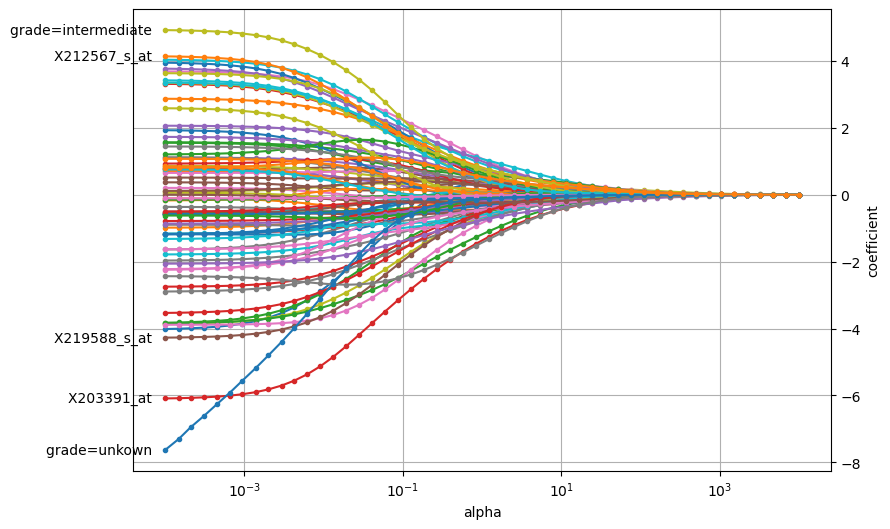

In [6]:
plot_coefficients(coefficients, n_highlight=5)

In [7]:
# lasso

In [8]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

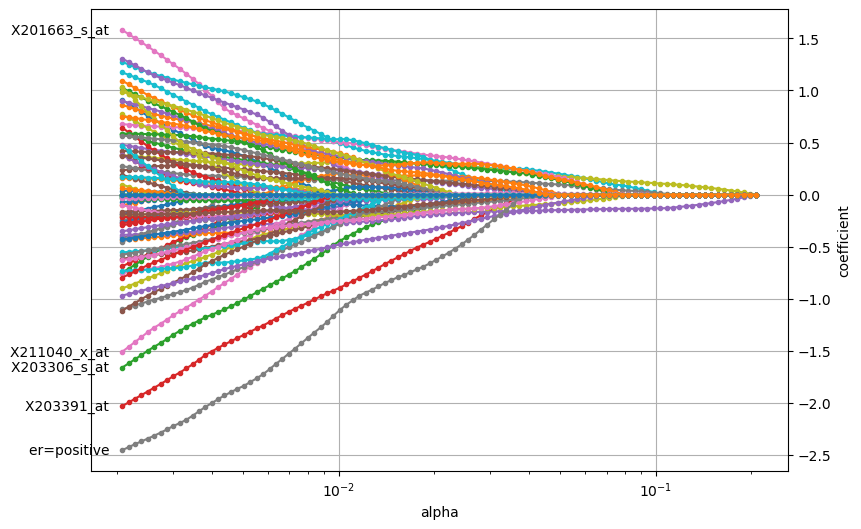

In [9]:

coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

In [10]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

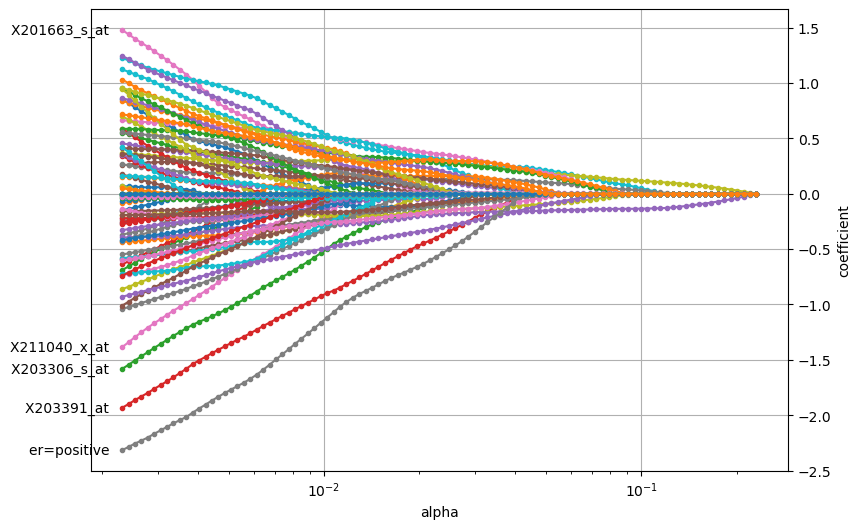

In [11]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [12]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

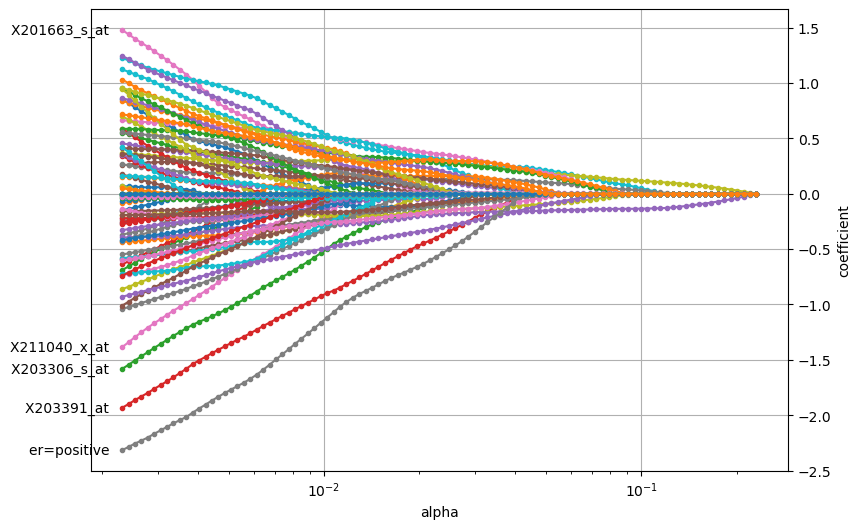

In [13]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [14]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [15]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

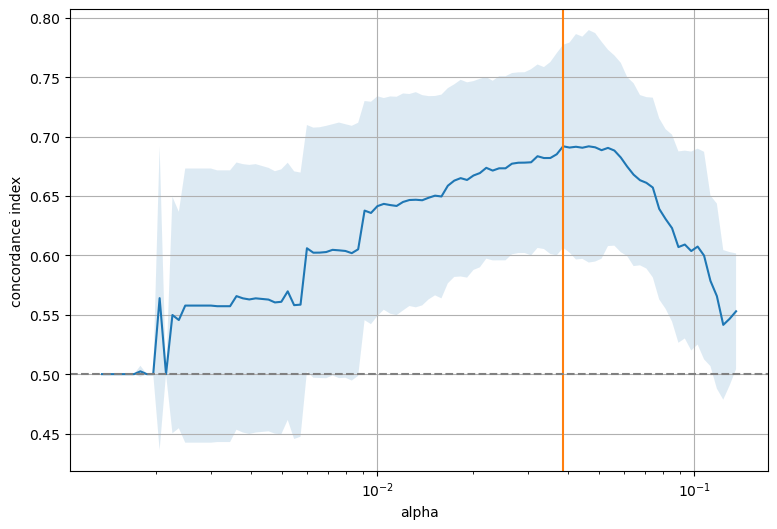

In [16]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 22


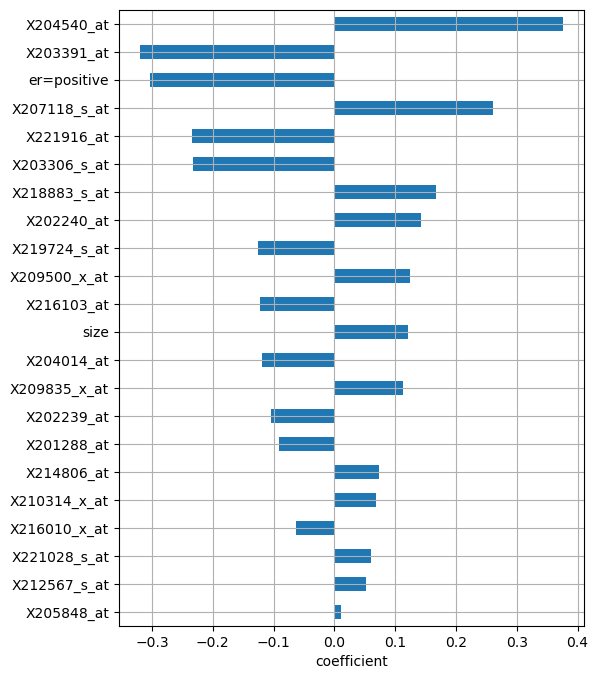

In [17]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [18]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.03860196504106796],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

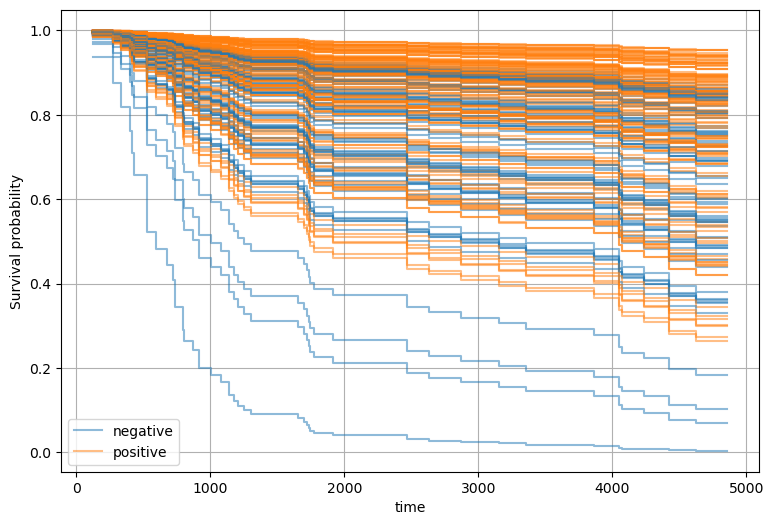

In [22]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["t.tdm"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, "er=positive"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [20]:
 Xt.loc[:, "er=positive"].astype(int)

0      0
1      1
2      0
3      1
4      1
      ..
193    0
194    0
195    1
196    1
197    0
Name: er=positive, Length: 198, dtype: int64

In [23]:
y["t.tdm"]

array([ 723., 6591.,  524., 6255., 3822., 6507., 5947., 5816., 6007.,
       1233., 1136., 5984., 6249., 4066.,  690.,  994.,  434., 1743.,
       2863., 5693., 5823., 5785., 5661., 2909., 1171., 5110., 5533.,
       5571., 5519., 5379., 4675., 4652., 4227.,  910., 4472., 1206.,
       7057.,  958., 5359., 5945., 5651.,  528.,  796., 5685., 1023.,
       4791., 1215., 3779., 5306., 5678.,  421., 5612., 3121., 1104.,
       4691., 5238., 5101., 2809., 3296., 3555., 5433., 5228., 5316.,
       4925., 5012., 4642., 3311., 4863., 1815.,  803., 2105.,  530.,
       4830., 1721., 4720., 1259., 3976., 4050., 1740., 3608., 3900.,
       1554., 3544., 3721., 3771., 3293., 3800., 4415.,  649., 4952.,
       1693., 4603., 4857., 4681., 2965., 4596., 1112., 1918., 1731.,
       4327., 4352., 4181., 3188., 2672.,  730., 1591., 1920., 2647.,
        269., 1290., 4568., 4537., 5035., 2604.,  394., 6777., 2549.,
       4085., 2892., 5236., 5406., 4279., 5359., 3964.,  289., 6298.,
       6399., 5683.,